<a href="https://colab.research.google.com/github/mmender2/DataScience/blob/main/EnsLicPl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages and Imports

In [ ]:
!pip install -U openmim --quiet
!mim install mmengine --quiet
!mim install 'mmcv>=2.0.0rc1' --quiet
!mim install 'mmdet>=3.0.0rc0' --quiet
!pip install google-cloud-vision --quiet
!pip install pytesseract Pillow --quiet
!sudo apt install tesseract-ocr --quiet
!pip install pytesseract --quiet
!pip install huggingface-cli --quiet
!huggingface-cli login --quiet
!pip install transformers --quiet
!pip install google-cloud-aiplatform --quiet

In [ ]:
!pip install Levenshtein

In [ ]:
!echo "deb [signed-by=/usr/share/keyrings/cloud.google.gpg] https://packages.cloud.google.com/apt cloud-sdk main" | sudo tee -a /etc/apt/sources.list.d/google-cloud-sdk.list
!apt-get install apt-transport-https ca-certificates gnupg
!wget -qO - https://packages.cloud.google.com/apt/doc/apt-key.gpg | gpg --dearmor -o /usr/share/keyrings/cloud-archive-keyring.gpg
!echo "deb [signed-by=/usr/share/keyrings/cloud-archive-keyring.gpg] http://packages.cloud.google.com/apt cloud-sdk main" | tee -a /etc/apt/sources.list.d/google-cloud-sdk.list
!sudo apt-get update
!sudo apt-get install google-cloud-sdk
!apt-get update -y && apt-get install google-cloud-sdk -y


In [4]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
# Install the Google Cloud SDK
!curl https://sdk.cloud.google.com | bash --quiet
!gcloud init
!gcloud components update --quiet
!gcloud components install beta --quiet

In [6]:
from google.cloud import aiplatform
#region = !gcloud config get-value compute/region
aiplatform.init(project='fifth-composite-395916', location='us-central1')

In [ ]:
# Download and install Google Cloud SDK
!curl https://sdk.cloud.google.com | bash --quiet

# Add gcloud to PATH
import os
os.environ['PATH'] += ":/root/google-cloud-sdk/bin"

# Authenticate with gcloud
!gcloud auth login


In [ ]:
# Copy the contents from the provided Google Cloud Storage path
!gsutil cp gs://vertex-ai/generative-ai/vision/multimodalembedding/* .

# Install the required Python packages
!pip3 install -r requirements.txt --quiet

In [ ]:
!gcloud config set project 'fifth-composite-395916'
import os
os.environ["GOOGLE_CLOUD_PROJECT"] = "fifth-composite-395916"

In [ ]:
"""from google.colab import files
uploaded = files.upload()"""

In [ ]:
!git clone https://github.com/open-mmlab/mmocr.git --quiet
%cd mmocr
!pip install -v -e . --quiet
# "-v" increases pip's verbosity.
# "-e" means installing the project in editable mode,
# That is, any local modifications on the code will take effect immediately.

In [ ]:
from mmocr.apis import MMOCRInferencer
infer = MMOCRInferencer(rec='svtr-small')

In [ ]:
!pip uninstall protobuf --quiet
!pip install protobuf --quiet
!pip install tensorflow --upgrade --quiet

In [ ]:
!pip install jax --upgrade
!pip install protobuf==3.20.3 --quiet

In [15]:
from keras.layers import Input, Conv2D, Lambda, Dense, Flatten, MaxPooling2D
from keras.models import Model, Sequential
from keras import backend as K
from sklearn.preprocessing import LabelEncoder
import random
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.metrics import pairwise_distances
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Dense, Dropout, LSTM, Bidirectional, Dropout, BatchNormalization
from keras.models import Model
import matplotlib.pyplot as plt
from itertools import combinations
import numpy as np
from mmocr.apis import MMOCRInferencer
import os
from google.cloud import vision
import pytesseract
from PIL import Image
import requests
import warnings
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import re

# Functions and Data Processing

In [16]:
data_path = '/content/drive/MyDrive/LicensePlate/states'
size = (512, 512)

# Function to load and preprocess images
def load_and_preprocess_images(image_paths, target_size=size):
    images = []
    for path in image_paths:
        # Load image and resize it to the target size
        img = load_img(path, target_size=target_size)
        # Convert image to array
        img_array = img_to_array(img)
        images.append(img_array)
    # Normalize the images to [0, 1] range and return
    return images / 255.0

# Function to extract labels from given image paths
def extract_labels_from_paths(paths):
    # Extracts the directory name as label from the path
    return [os.path.basename(os.path.dirname(path)) for path in paths]

# Function to create pairs of images
def create_pairs(images, labels):
    pairs = []
    pair_labels = []

    num_classes = max(labels) + 1
    # Create a list of indices for each label
    class_indices = [np.where(labels == i)[0] for i in range(num_classes)]

    for i in range(len(images)):
        positive_index = i
        # Choose a random index from a different class for negative pairing
        negative_index = np.random.choice(class_indices[(labels[i] + 1) % num_classes])

        # Positive pair and its label
        pairs += [[images[i], images[positive_index]]]
        pair_labels += [1]

        # Negative pair and its label
        pairs += [[images[i], images[negative_index]]]
        pair_labels += [0]

    return np.array(pairs), np.array(pair_labels)

from sklearn.preprocessing import LabelEncoder

def create_metadata(data_path):
    image_paths = []
    labels = []

    # List all files in the data_path directory
    file_names = os.listdir(data_path)

    for file_name in file_names:
        # Check if the file is an image with .png extension
        if file_name.endswith('.png'):
            image_paths.append(os.path.join(data_path, file_name))

            # Assuming file_name is in the format 'state_name.png'
            # Extracting the state name as label by stripping '.png' from the end.
            labels.append(file_name[:-4])

    # Create a DataFrame with image paths and their corresponding labels
    meta_data = pd.DataFrame(
        {
            'image_paths': image_paths,
            'labels': labels
        }, dtype=object
    )
    return meta_data

# Create metadata for the images in the provided data path
data = create_metadata(data_path)
print(data.shape)

# Display a random sample of 5 rows from the metadata
data.sample(5)


(50, 2)


,image_paths,labels
10,/content/drive/MyDrive/LicensePlate/states/haw...,hawaii
18,/content/drive/MyDrive/LicensePlate/states/mai...,maine
37,/content/drive/MyDrive/LicensePlate/states/sou...,south carolina
11,/content/drive/MyDrive/LicensePlate/states/ida...,idaho
44,/content/drive/MyDrive/LicensePlate/states/wis...,wisconsin


In [ ]:
# Initialize TrOCR
url = 'https://fki.tic.heia-fr.ch/static/img/a01-122-02-00.jpg'
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-large-printed')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-large-printed')
# Suppress specific warnings
np.seterr(divide='ignore', invalid='ignore')
warnings.filterwarnings("ignore", category=RuntimeWarning)
# Initialize the MMOCR inferencer without KIE
infer = MMOCRInferencer(det='dbnetpp', rec='svtr-small')
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/content/drive/MyDrive/LicensePlate/fifth-composite-395916-8a836430659f.json"
# Initialize the Vision client
client = vision.ImageAnnotatorClient()

In [18]:
import string
# Add lowercase letters to the set of characters and regenerate the mapping
all_characters = sorted(set(string.ascii_uppercase + string.ascii_lowercase + string.digits))

char_to_num = {char: i for i, char in enumerate(all_characters)}
num_to_char = {i: char for char, i in char_to_num.items()}

#num_to_char

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def data_generator(data_sample, char_to_num):
    pltI = []  # List to store preprocessed images
    edge = []  # List to store edge-detected images
    labels = []  # List to store the labels associated with each image

    for index, sample in enumerate(data_sample):
        # Extract image path and associated label from the sample
        image_path = sample['image_paths']
        label_text = sample['labels']

        # Read the image in grayscale mode and resize to (512, 512)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (512, 512))

        # Check if image reading was successful
        if image is None:
            print(f"Failed to read image at index {index} with path: {image_path}")
            continue

        # Apply morphological top-hat operation to emphasize light regions against a dark background
        structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        imgTopHat = cv2.morphologyEx(image, cv2.MORPH_TOPHAT, structuringElement)

        # Apply morphological black-hat operation to emphasize dark regions against a light background
        imgBlackHat = cv2.morphologyEx(image, cv2.MORPH_BLACKHAT, structuringElement)

        # Enhance the image by adding the result of the top-hat operation and subtracting the result of the black-hat operation
        imgGrayscalePlusTopHat = cv2.add(image, imgTopHat)
        image = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

        # Apply Gaussian blur to reduce image noise
        img_blurred = cv2.GaussianBlur(image, ksize=(5, 5), sigmaX=0)

        # Apply adaptive thresholding to binarize the image
        thresh_image = cv2.adaptiveThreshold(
            img_blurred,
            255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY,
            65,
            2
        )

        # Detect contours in the binarized image
        contours, _= cv2.findContours(
            thresh_image,
            mode=cv2.RETR_LIST,
            method=cv2.CHAIN_APPROX_SIMPLE
        )

        # Initialize a blank image to draw the contours
        temp_result = np.zeros((512, 512), dtype=np.uint8)

        # Draw the detected contours on the blank image
        cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=255, thickness=-1)

        # Invert the image (make black regions white and vice versa)
        inverted_temp_result = cv2.bitwise_not(temp_result)

        # Apply Canny edge detection on the inverted image
        edges = cv2.Canny(inverted_temp_result, 50, 150)

        # Store the preprocessed image, edge-detected image, and label into their respective lists
        pltI.append(inverted_temp_result)
        edge.append(edges)
        labels.append(label_text)

    # Return the lists containing preprocessed images, edge-detected images, and labels
    return pltI, edge, labels


In [20]:
from sklearn.model_selection import train_test_split
from math import ceil

#dataSample = data.sample(n=len(data), random_state=42).reset_index(drop=True)
data_list = data[['image_paths', 'labels']].to_dict('records')

# Split the data_list into training and validation sets (e.g., 80% train, 20% validation)
train_data, val_data = train_test_split(data_list, test_size=0.4, random_state=42)

batch_size = 32
train_steps_per_epoch = len(train_data) // batch_size  # This will give 84
val_steps_per_epoch = len(val_data) // batch_size  # This will give 56

In [21]:
# Create the two generators
#train_gen = data_generator(train_data, char_to_num, batch_size=batch_size)
#val_gen = data_generator(val_data, char_to_num, batch_size=batch_size)
# Test the generators
#train_inputs, train_outputs = next(train_gen)
#val_inputs, val_outputs = next(val_gen)
processed_images, processed_edges, image_labels = data_generator(data_list, char_to_num)
#processed_images, image_labels = data_generator(data_list, char_to_num)

#final_inputs = next(final)


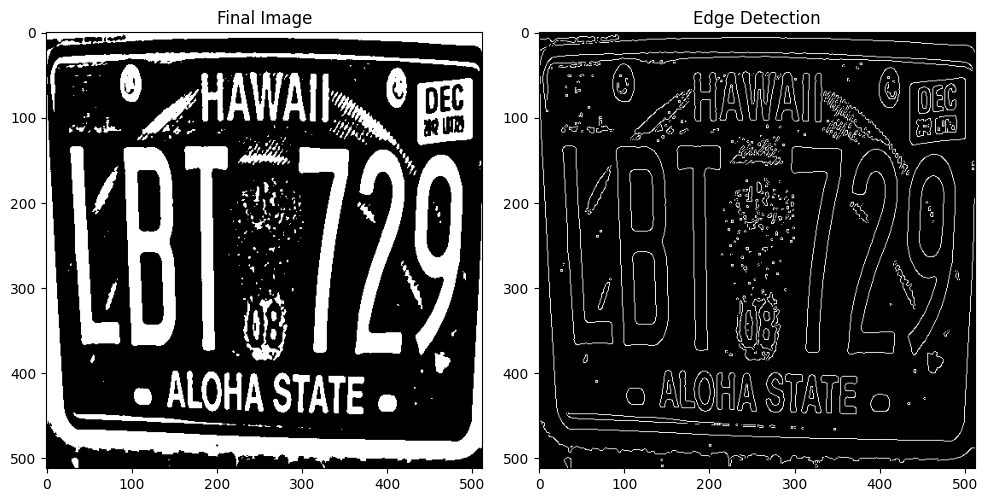

In [22]:
# Display the result
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(processed_images[10], cmap='gray')
plt.title('Final Image')

plt.subplot(1, 2, 2)
plt.imshow(processed_edges[10], cmap='gray')
plt.title('Edge Detection')

plt.tight_layout()
plt.show()

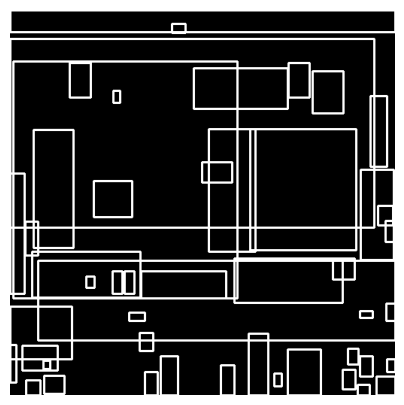

In [23]:
'''

****************** WORK IN POGRESS THE BOX DETECTION STUFF *****************

'''

boxes = []
height, width = 512, 512
contours_dict = []
min_contour_area = 50  # Adjust this value.

for img in processed_images:
    # Initialize a blank image for each processed image
    temp_result = np.zeros((height, width), dtype=np.uint8)

    grayscale_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape) == 3 else img

    # Morphological operations
    kernel = np.ones((3, 3), np.uint8)
    dilation = cv2.dilate(grayscale_img, kernel, iterations=1)
    erosion = cv2.erode(dilation, kernel, iterations=1)

    contours, _ = cv2.findContours(erosion, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        area = cv2.contourArea(contour)
        if area > min_contour_area:  # Only consider contours that are above the minimum area threshold
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(temp_result, pt1=(x, y), pt2=(x+w, y+h), color=(255, 255, 255), thickness=2)

            # insert to dict
            contours_dict.append({
                'contour': contour,
                'x': x,
                'y': y,
                'w': w,
                'h': h,
                'cx': x + (w / 2),
                'cy': y + (h / 2)
            })
            boxes.append(temp_result)


plt.figure(figsize=(5, 5))
plt.imshow(boxes[10], cmap='gray')
plt.axis('off')
plt.show()


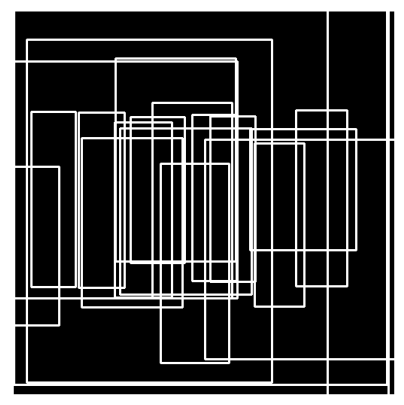

In [24]:
'''

****************** WORK IN POGRESS THE BOX DETECTION STUFF *****************

'''

MIN_AREA = 12500
MIN_WIDTH, MIN_HEIGHT = 2, 8
MIN_RATIO, MAX_RATIO = 0.25, 1.0

possible_contours = []
bx = []
cnt = 0
for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']

    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)

# visualize possible contours
temp_result = np.zeros((height, height), dtype=np.uint8)

for d in possible_contours:
#     cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)
    bx.append(temp_result)
plt.figure(figsize=(5, 5))
plt.imshow(bx[10], cmap='gray')
plt.axis('off')
plt.show()

In [25]:
# List of US States
us_states = [
    'alabama', 'alaska', 'arizona', 'arkansas', 'california', 'colorado',
    'connecticut', 'delaware', 'florida', 'georgia', 'hawaii', 'idaho', 'illinois',
    'indiana', 'iowa', 'kansas', 'kentucky', 'louisiana', 'maine', 'maryland',
    'massachusetts', 'michigan', 'minnesota', 'mississippi', 'missouri', 'montana',
    'nebraska', 'nevada', 'new hampshire', 'new jersey', 'new mexico', 'new york',
    'north carolina', 'north dakota', 'ohio', 'oklahoma', 'oregon', 'pennsylvania',
    'rhode island', 'south carolina', 'south dakota', 'tennessee', 'texas', 'utah',
    'vermont', 'virginia', 'washington', 'west virginia', 'wisconsin', 'wyoming'
]

In [26]:
from google.cloud import vision
import Levenshtein

# Function to extract texts using Google Cloud Vision API
def get_texts_from_google_vision(img_data):
    texts_list = []  # Initialize an empty list to store the texts

    # Convert the numpy image to bytes
    success, encoded_image = cv2.imencode('.jpg', img_data)
    image_bytes = encoded_image.tobytes()

    client = vision.ImageAnnotatorClient()  # Initialize the Google Cloud Vision client

    image = vision.Image(content=image_bytes)

    # Text Detection using Google Vision API
    response = client.text_detection(image=image)
    texts = response.text_annotations

    # If texts are detected, check if they match any US state name
    if texts:
        for text in texts:
            detected_text = text.description
            if detected_text.lower() in us_states:
                texts_list.append(detected_text)  # Add the detected text to the list
                break

    return texts_list  # Always return a list, even if it's empty

# Function to extract sequences of characters from detected texts
def extract_sequences(img_data, detected_state):
    """Extract sequences of 6 or 7 characters (letters and/or numbers) from the text."""

    # Get sequences from Google Cloud Vision first
    gcv_sequences = get_license_plate_sequences(img_data)
    gcv_sequences = [seq for seq in gcv_sequences if re.search(r'[A-Za-z]', seq) and re.search(r'[0-9]', seq)]

    if gcv_sequences:
        return gcv_sequences

    # Define regex patterns based on detected state
    if detected_state.lower() in ['california', 'new york', 'new jersey']:
        pattern = r'\b\w{5,8}\b'
    else:
        pattern = r'\b\w{5,7}\b'

    # Extract text from TrOCR and then apply regex to extract sequences
    trocr_text = get_text_from_trocr(img_data).lower()
    return re.findall(pattern, trocr_text)

# Function to extract text from an image using TrOCR
def get_text_from_trocr(image_data):
    pil_img = Image.fromarray(image_data)
    inputs = processor(pil_img, return_tensors="pt")
    pixel_values = inputs["pixel_values"]

    # Generate text from the image using the TrOCR model
    generated_ids = model.generate(pixel_values, max_new_tokens=50)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)

    return generated_text[0].strip()

# Function to extract text and its confidence score using Google Vision API
def get_text_from_google_vision2(image_data):
    if isinstance(image_data, np.ndarray):
        is_success, image_buffer = cv2.imencode(".jpg", image_data)
        image_data = image_buffer.tobytes()

    client = vision.ImageAnnotatorClient()  # Initialize the Google Cloud Vision client
    image = vision.Image(content=image_data)
    response = client.text_detection(image=image)

    texts_with_confidence = [{"description": text.description, "confidence": text.confidence} for text in response.text_annotations]

    return texts_with_confidence

# Function to extract text from an image using Tesseract OCR
def get_text_from_tesseract(image_data):
    image = Image.fromarray(image_data)
    text = pytesseract.image_to_string(image).strip()
    return text

# Function to convert a grayscale image to RGB
def grayscale_to_rgb(grayscale_img):
    return np.repeat(grayscale_img[..., np.newaxis], 3, axis=2)

# Function to invert colors of an image
def invert_colors(image):
    return 255 - image

# Function to get multimodal embeddings using AI Platform
def get_multimodal_embeddings(image, text):
    client = aiplatform.gapic.VizierServiceClient(client_options={"api_endpoint": "us-central1-aiplatform.googleapis.com"})

    request = aiplatform.gapic.PredictRequest(
        endpoint="YOUR_ENDPOINT",
        instances=[
            {
                "image": {"content": image},  # Image should be base64 encoded
                "text": text
            }
        ]
    )

    response = client.predict(request)
    embeddings = response.predictions[0]  # Assumes one embedding is returned. Adjust if necessary.
    return embeddings

# Function to extract license plate sequences from an image using Google Vision API
def get_license_plate_sequences(img_data):
    height, width, _ = img_data.shape

    # Crop the middle of the image to focus on the license plate
    top = int(height * 2/5)
    bottom = int(height * 4/5)
    cropped_image = img_data[top:bottom, :]

    _, encoded_image = cv2.imencode('.png', cropped_image)
    image_bytes = encoded_image.tobytes()

    client = vision.ImageAnnotatorClient()  # Initialize the Google Cloud Vision client

    image = vision.Image(content=image_bytes)
    response = client.text_detection(image=image)
    texts = response.text_annotations

    # Filter the detected texts to get potential license plate sequences
    sequences = []
    for text in texts:
        if len(text.description) >= 5 and len(text.description) <= 8:
            sequences.append(text.description)

    if len(sequences) > 1:
        return sequences[0]
    else:
        return sequences

# Function to find the closest matching state to the detected text
def find_closest_state(detected_text, state_list):
    distances = [(state, Levenshtein.distance(detected_text, state)) for state in state_list]
    distances.sort(key=lambda x: x[1])
    return distances[0][0]

# Function to check if detected text is similar to any US state name
def is_similar_to_any_state(detected_text, threshold=0.7):
    closest_state = find_closest_state(detected_text, us_states)
    if closest_state.lower() in detected_text.lower():
        return closest_state.capitalize()
    return None
# Function to set the name of the model used for prediction
def set_model_name(model_name, x):
    if not x:
        x = model_name
    return x
# Function to invert the colors of an image
def invert_colors(img):
    return 255 - img

# Function to convert a grayscale image to RGB format
def grayscale_to_rgb(img):
    if len(img.shape) == 2 or img.shape[2] == 1:  # Check if the image is grayscale
        return cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    return img  # return original image if it's already RGB


# Model

In [27]:
from tqdm import tqdm

# Invert colors of processed images
inverted_image = [invert_colors(img) for img in processed_images]
grayscale_images = inverted_image
# Convert grayscale images to RGB
rgb_images = [grayscale_to_rgb(img) for img in grayscale_images]

predicted_results = {}

# Process each image in the dataset
for index, img_data in tqdm(enumerate(rgb_images), total=len(rgb_images), desc="Processing images"):
    detected_states = set()
    detected_numbers = set()
    x = None
    state_detected = False

    print(f"Starting processing for image {index}")

    # Try to detect text using Google Vision API
    google_texts_results = get_texts_from_google_vision(img_data)
    for text_data in google_texts_results:
        detected_state = is_similar_to_any_state(text_data)
        if detected_state:
            detected_states.add(detected_state)
            x = set_model_name('Google Vision', x)
            state_detected = True
            break

    # If not detected, try MMOCR
    if not state_detected:
        result = infer(img_data, save_vis=False)
        for prediction in result['predictions']:
            rec_texts = prediction.get('rec_texts', [])
            for detected_text in rec_texts:
                detected_state = is_similar_to_any_state(detected_text)
                if detected_state:
                    detected_states.add(detected_state)
                    x = set_model_name('MMOCR', x)
                    state_detected = True
                    break
            if state_detected:
                break

    # If not detected, try Google Vision API again (different function)
    if not state_detected:
        google_vision_texts = get_text_from_google_vision2(img_data)
        for text_data in google_vision_texts:
            detected_text = text_data["description"]
            detected_state = is_similar_to_any_state(detected_text)
            if detected_state:
                detected_states.add(detected_state)
                x = set_model_name('Google Vision 2', x)
                state_detected = True
                break

    # If not detected, try Tesseract OCR
    if not state_detected:
        tesseract_text = get_text_from_tesseract(inverted_image[index]).lower()
        detected_state = is_similar_to_any_state(tesseract_text)
        if detected_state:
            detected_states.add(detected_state)
            x = set_model_name('Tesseract', x)
            state_detected = True

    # If not detected, try TrOCR
    if not state_detected:
        trocr_text = get_text_from_trocr(img_data).lower()
        detected_state = is_similar_to_any_state(trocr_text)
        if detected_state:
            detected_states.add(detected_state)
            x = set_model_name('TrOCR', x)
            state_detected = True

    # If state is still not detected, find the closest matching state
    if not state_detected:
        potential_state = find_closest_state(trocr_text, us_states)
        detected_states.add(potential_state.capitalize())
        x = set_model_name('Similarity Check', x)
        state_detected = True

    if state_detected:
        # Extract license plate numbers using Google Vision
        sequences_found = get_license_plate_sequences(img_data)
        sequences_found = [seq for seq in sequences_found if re.search(r'[A-Za-z]', seq) and re.search(r'[0-9]', seq)]
        if not sequences_found:
            sequences_found = extract_sequences(img_data, list(detected_states)[0] if detected_states else "")

        detected_numbers.update(sequences_found)

    # Store the results
    label_for_image = image_labels[index]
    if label_for_image in predicted_results:  # Checking if label already exists
        label_for_image += f"_{index}"  # Modify the label with index to make it unique

    predicted_results[label_for_image] = {
        'State': list(detected_states) if detected_states else ["NoPrediction"],
        'Number': list(detected_numbers) if detected_numbers else ["NoNumber"],
        'Model': x
    }

    print(f"Saved results for image {label_for_image}")

print('\n')
x = 0
for label, details in predicted_results.items():
    state = ', '.join(details['State'])
    numbers = ', '.join(details['Number'])
    model_used = details['Model']
    if numbers == "NoNumber":
      x += 1
    print(f"Image {label}: State(s) - {state} | Number(s) - {numbers} | Model - {model_used}")
print(x)


Processing images:   0%|          | 0/50 [00:00<?, ?it/s]

Starting processing for image 0


Processing images:   2%|▏         | 1/50 [00:02<01:44,  2.14s/it]

Saved results for image alabama
Starting processing for image 1


Processing images:   4%|▍         | 2/50 [00:03<01:27,  1.82s/it]

Saved results for image alaska
Starting processing for image 2


Output()

Processing images:   6%|▌         | 3/50 [00:08<02:21,  3.02s/it]

Saved results for image arizona
Starting processing for image 3


Processing images:   8%|▊         | 4/50 [00:08<01:32,  2.02s/it]

Saved results for image arkansas
Starting processing for image 4


Processing images:  10%|█         | 5/50 [00:10<01:23,  1.85s/it]

Saved results for image california
Starting processing for image 5


Output()

Processing images:  12%|█▏        | 6/50 [00:13<01:39,  2.26s/it]

Saved results for image colorado
Starting processing for image 6


Processing images:  14%|█▍        | 7/50 [00:15<01:32,  2.15s/it]

Saved results for image connecticut
Starting processing for image 7


Output()

Processing images:  16%|█▌        | 8/50 [00:18<01:50,  2.64s/it]

Saved results for image delaware
Starting processing for image 8


Output()

Processing images:  18%|█▊        | 9/50 [00:22<02:02,  2.99s/it]

Saved results for image florida
Starting processing for image 9


Output()

Processing images:  20%|██        | 10/50 [00:26<02:05,  3.13s/it]

Saved results for image georgia
Starting processing for image 10


Output()

Processing images:  22%|██▏       | 11/50 [00:29<02:05,  3.23s/it]

Saved results for image hawaii
Starting processing for image 11


Output()

Processing images:  24%|██▍       | 12/50 [00:35<02:38,  4.16s/it]

Saved results for image idaho
Starting processing for image 12


Processing images:  26%|██▌       | 13/50 [00:37<02:11,  3.55s/it]

Saved results for image illinois
Starting processing for image 13


Output()

Processing images:  28%|██▊       | 14/50 [00:41<02:05,  3.49s/it]

Saved results for image indiana
Starting processing for image 14


Output()

Processing images:  30%|███       | 15/50 [00:44<02:03,  3.52s/it]

Saved results for image iowa
Starting processing for image 15


Output()

Processing images:  32%|███▏      | 16/50 [00:48<01:59,  3.50s/it]

Saved results for image kansas
Starting processing for image 16


Processing images:  34%|███▍      | 17/50 [00:50<01:40,  3.06s/it]

Saved results for image kentucky
Starting processing for image 17


Processing images:  36%|███▌      | 18/50 [00:52<01:26,  2.69s/it]

Saved results for image louisiana
Starting processing for image 18


Output()

Processing images:  38%|███▊      | 19/50 [00:54<01:14,  2.42s/it]

Saved results for image maine
Starting processing for image 19


Output()

Processing images:  40%|████      | 20/50 [00:57<01:18,  2.62s/it]

Saved results for image maryland
Starting processing for image 20


Processing images:  42%|████▏     | 21/50 [00:57<00:57,  1.97s/it]

Saved results for image massachusetts
Starting processing for image 21


Output()

Processing images:  44%|████▍     | 22/50 [01:01<01:08,  2.44s/it]

Saved results for image michigan
Starting processing for image 22


Output()

Processing images:  46%|████▌     | 23/50 [01:04<01:14,  2.74s/it]

Saved results for image minnesota
Starting processing for image 23


Processing images:  48%|████▊     | 24/50 [01:06<01:05,  2.52s/it]

Saved results for image missouri
Starting processing for image 24


Output()

Processing images:  50%|█████     | 25/50 [01:09<01:03,  2.56s/it]

Saved results for image montana
Starting processing for image 25


Output()

Processing images:  52%|█████▏    | 26/50 [01:13<01:11,  2.98s/it]

Saved results for image nebraska
Starting processing for image 26


Output()

Processing images:  54%|█████▍    | 27/50 [01:17<01:18,  3.40s/it]

Saved results for image nevada
Starting processing for image 27


Output()

Processing images:  56%|█████▌    | 28/50 [01:21<01:18,  3.57s/it]

Saved results for image new hampshire
Starting processing for image 28


Output()

Processing images:  58%|█████▊    | 29/50 [01:23<01:05,  3.12s/it]

Saved results for image new jersey
Starting processing for image 29


Output()

Processing images:  60%|██████    | 30/50 [01:26<01:03,  3.17s/it]

Saved results for image new mexico
Starting processing for image 30


Output()

Processing images:  62%|██████▏   | 31/50 [01:30<01:02,  3.27s/it]

Saved results for image new york
Starting processing for image 31


Output()

Processing images:  64%|██████▍   | 32/50 [01:33<00:59,  3.31s/it]

Saved results for image north carolina
Starting processing for image 32


Output()

Processing images:  66%|██████▌   | 33/50 [01:38<01:02,  3.69s/it]

Saved results for image north dakota
Starting processing for image 33


Output()

Processing images:  68%|██████▊   | 34/50 [01:41<00:56,  3.53s/it]

Saved results for image ohio
Starting processing for image 34


Output()

Processing images:  70%|███████   | 35/50 [01:45<00:53,  3.60s/it]

Saved results for image oklahoma
Starting processing for image 35


Processing images:  72%|███████▏  | 36/50 [01:45<00:37,  2.66s/it]

Saved results for image oregon
Starting processing for image 36


Output()

Processing images:  74%|███████▍  | 37/50 [01:49<00:37,  2.88s/it]

Saved results for image pennsylvania
Starting processing for image 37


Output()

Processing images:  76%|███████▌  | 38/50 [01:50<00:30,  2.54s/it]

Saved results for image south carolina
Starting processing for image 38


Output()

Processing images:  78%|███████▊  | 39/50 [01:53<00:29,  2.66s/it]

Saved results for image south dakota
Starting processing for image 39


Processing images:  80%|████████  | 40/50 [01:55<00:23,  2.34s/it]

Saved results for image tennessee
Starting processing for image 40


Output()

Processing images:  82%|████████▏ | 41/50 [01:57<00:19,  2.18s/it]

Saved results for image texas
Starting processing for image 41


Output()

Processing images:  84%|████████▍ | 42/50 [02:00<00:20,  2.57s/it]

Saved results for image utah
Starting processing for image 42


Processing images:  86%|████████▌ | 43/50 [02:01<00:13,  1.98s/it]

Saved results for image vermont
Starting processing for image 43


Output()

Processing images:  88%|████████▊ | 44/50 [02:04<00:13,  2.33s/it]

Saved results for image virginia
Starting processing for image 44


Output()

Processing images:  90%|█████████ | 45/50 [02:07<00:13,  2.67s/it]

Saved results for image wisconsin
Starting processing for image 45


Output()

Processing images:  92%|█████████▏| 46/50 [02:10<00:11,  2.77s/it]

Saved results for image wyoming
Starting processing for image 46


Output()

Processing images:  94%|█████████▍| 47/50 [02:15<00:10,  3.35s/it]

Saved results for image mississippi
Starting processing for image 47


Output()

Processing images:  96%|█████████▌| 48/50 [02:19<00:06,  3.37s/it]

Saved results for image rhode island
Starting processing for image 48


Output()

Processing images:  98%|█████████▊| 49/50 [02:22<00:03,  3.39s/it]

Saved results for image washington
Starting processing for image 49


Processing images: 100%|██████████| 50/50 [02:24<00:00,  2.89s/it]

Saved results for image west virginia


Image alabama: State(s) - Alabama | Number(s) - bc18351 | Model - Google Vision
Image alaska: State(s) - Alaska | Number(s) - NoNumber | Model - Google Vision
Image arizona: State(s) - Texas | Number(s) - ate3415 | Model - Similarity Check
Image arkansas: State(s) - Arkansas | Number(s) - 013 KTI | Model - Google Vision
Image california: State(s) - California | Number(s) - strmceo | Model - Google Vision
Image colorado: State(s) - Colorado | Number(s) - NoNumber | Model - MMOCR
Image connecticut: State(s) - Connecticut | Number(s) - NoNumber | Model - Google Vision
Image delaware: State(s) - Delaware | Number(s) - 120596 | Model - MMOCR
Image florida: State(s) - Florida | Number(s) - NoNumber | Model - MMOCR
Image georgia: State(s) - Georgia | Number(s) - 99238 | Model - MMOCR
Image hawaii: State(s) - Texas | Number(s) - LB1 729 | Model - Similarity Check
Image idaho: State(s) - Kansas | Number(s) - 482921 | Model - Similarity Check
Image illinoi

# Multimodel Embedding - Work in progress


In [ ]:
!python3 predict_request_gapic.py --text 'license plate from alaska' --image_file '/content/drive/MyDrive/LicensePlate/states/alaska.png' --project 'fifth-composite-395916'


In [31]:
data_path = '/content/drive/MyDrive/LicensePlate/archive/data'
size = (512, 512)

# Function to load and preprocess images
def load_and_preprocess_images(image_paths, target_size=size):
    images = []
    for path in image_paths:
        # Load image and resize it to the target size
        img = load_img(path, target_size=target_size)
        # Convert image to array
        img_array = img_to_array(img)
        images.append(img_array)
    # Normalize the images to [0, 1] range and return
    return images / 255.0

# Function to extract labels from given image paths
def extract_labels_from_paths(paths):
    # Extracts the directory name as label from the path
    return [os.path.basename(os.path.dirname(path)) for path in paths]

# Function to create pairs of images
def create_pairs(images, labels):
    pairs = []
    pair_labels = []

    num_classes = max(labels) + 1
    # Create a list of indices for each label
    class_indices = [np.where(labels == i)[0] for i in range(num_classes)]

    for i in range(len(images)):
        positive_index = i
        # Choose a random index from a different class for negative pairing
        negative_index = np.random.choice(class_indices[(labels[i] + 1) % num_classes])

        # Positive pair and its label
        pairs += [[images[i], images[positive_index]]]
        pair_labels += [1]

        # Negative pair and its label
        pairs += [[images[i], images[negative_index]]]
        pair_labels += [0]

    return np.array(pairs), np.array(pair_labels)

from sklearn.preprocessing import LabelEncoder

def create_metadata(data_path):
    image_paths = []
    labels = []

    # List all subdirectories in the data_path directory
    state_folders = [folder for folder in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, folder))]

    for state_folder in state_folders:
        # List all files in the state_folder
        file_names = os.listdir(os.path.join(data_path, state_folder))

        for file_name in file_names:
            # Check if the file is an image with .png extension
            if file_name.endswith('.jpg'):
                image_paths.append(os.path.join(data_path, state_folder, file_name))
                labels.append(state_folder)

    # Create a DataFrame with image paths and their corresponding labels
    meta_data = pd.DataFrame(
        {
            'image_paths': image_paths,
            'labels': labels
        }, dtype=object
    )
    return meta_data

# Create metadata for the images in the provided data path
data = create_metadata(data_path)
print(data.shape)

# Display a random sample of 5 rows from the metadata
data.sample(5)


(4493, 2)


,image_paths,labels
3745,/content/drive/MyDrive/LicensePlate/archive/da...,WestVirginia
2282,/content/drive/MyDrive/LicensePlate/archive/da...,Iowa
1307,/content/drive/MyDrive/LicensePlate/archive/da...,Maryland
967,/content/drive/MyDrive/LicensePlate/archive/da...,Texas
1797,/content/drive/MyDrive/LicensePlate/archive/da...,Michigan


In [32]:
from sklearn.model_selection import train_test_split
from math import ceil

#dataSample = data.sample(n=len(data), random_state=42).reset_index(drop=True)
data_list = data[['image_paths', 'labels']].to_dict('records')

# Split the data_list into training and validation sets (e.g., 80% train, 20% validation)
train_data, val_data = train_test_split(data_list, test_size=0.4, random_state=42)

batch_size = 32
train_steps_per_epoch = len(train_data) // batch_size  # This will give 84
val_steps_per_epoch = len(val_data) // batch_size  # This will give 56

In [86]:
# Create the two generators
#train_gen = data_generator(train_data, char_to_num, batch_size=batch_size)
#val_gen = data_generator(val_data, char_to_num, batch_size=batch_size)
# Test the generators
#train_inputs, train_outputs = next(train_gen)
#val_inputs, val_outputs = next(val_gen)

subset_size = 500
subset_data = random.sample(data_list, subset_size)
processed_images, processed_edges, image_labels = data_generator(subset_data, char_to_num)
#processed_images, image_labels = data_generator(data_list, char_to_num)

#final_inputs = next(final)


In [87]:
from google.cloud import aiplatform
from google.protobuf import struct_pb2
import base64

class EmbeddingPredictionClient:
    """Wrapper around Prediction Service Client."""
    def __init__(self, project : str,
        location : str = "us-central1",
        api_regional_endpoint: str = "us-central1-aiplatform.googleapis.com"):
        client_options = {"api_endpoint": api_regional_endpoint}
        # Initialize client that will be used to create and send requests.
        # This client only needs to be created once, and can be reused for multiple requests.
        self.client = aiplatform.gapic.PredictionServiceClient(client_options=client_options)
        self.location = location
        self.project = project

    def get_embedding(self, text : str = None, image_bytes : bytes = None):
        if not text and not image_bytes:
            raise ValueError('At least one of text or image_bytes must be specified.')

        instance = struct_pb2.Struct()
        if text:
            instance.fields['text'].string_value = text

        if image_bytes:
            encoded_content = base64.b64encode(image_bytes).decode("utf-8")
            image_struct = instance.fields['image'].struct_value
            image_struct.fields['bytesBase64Encoded'].string_value = encoded_content

        instances = [instance]
        endpoint = (f"projects/{self.project}/locations/{self.location}"
            "/publishers/google/models/multimodalembedding@001")
        response = self.client.predict(endpoint=endpoint, instances=instances)

        text_embedding = None
        if text:
            text_emb_value = response.predictions[0]['textEmbedding']
            text_embedding = [v for v in text_emb_value]

        image_embedding = None
        if image_bytes:
            image_emb_value = response.predictions[0]['imageEmbedding']
            image_embedding = [v for v in image_emb_value]

        return {
            'text_embedding': text_embedding,
            'image_embedding': image_embedding
        }


In [89]:
import cv2

def get_embedding_for_image_np(image_data, text, project):
    """Generate embedding for numpy image array using EmbeddingPredictionClient."""

    # Convert numpy array to bytes for passing to the client
    success, encoded_image = cv2.imencode('.png', image_data)
    image_bytes = encoded_image.tobytes()

    # Initialize the client
    client = EmbeddingPredictionClient(project=project)

    # Fetch the embedding
    response = client.get_embedding(text=text, image_bytes=image_bytes)

    return response

import time

# Assuming processed_images and image_labels are defined and have the same length

# Initialize the all_embeddings list
all_embeddings = []

# Number of samples per request
samples_per_request = 120

# Loop through processed_images in chunks to generate embeddings
for i in range(0, len(processed_images), samples_per_request):
    end = i + samples_per_request
    for img_data, state_label in zip(processed_images[i:end], image_labels[i:end]):
        input_text = f'license plate from {state_label.lower()}'  # Example: 'license plate from california'
        embedding = get_embedding_for_image_np(img_data, input_text, 'fifth-composite-395916')
        all_embeddings.append(embedding)

    # If it's not the last iteration, sleep for the remainder of the minute
    if end < len(processed_images):
        time.sleep(60)  # Wait for 60 seconds



In [90]:
# Save the embeddings to a JSON file
with open('embeddings_output.json', 'w') as file:
    json.dump(all_embeddings, file)


In [91]:
import json

with open('embeddings_output.json', 'r') as file:
    embeddings_data = json.load(file)

# 'embeddings_data' is now a list of embedding dictionaries
for embedding in embeddings_data:
    text_embedding = embedding['text_embedding']
    image_embedding = embedding['image_embedding']
    # Process the embeddings as needed


In [93]:
# Assuming all_embeddings is defined as a list of dictionaries

# Extract and concatenate text and image embeddings from all_embeddings
concatenated_embeddings = [sample['text_embedding'] + sample['image_embedding'] for sample in all_embeddings]

# Convert the concatenated embeddings to a numpy array
concatenated_embeddings_array = np.array(concatenated_embeddings)

# Apply t-SNE on the concatenated embeddings array
tsne = TSNE(n_components=2, random_state=0)
reduced_embeddings = tsne.fit_transform(concatenated_embeddings_array)

# Now, you can use the corrected_reduced_embeddings for visualization.


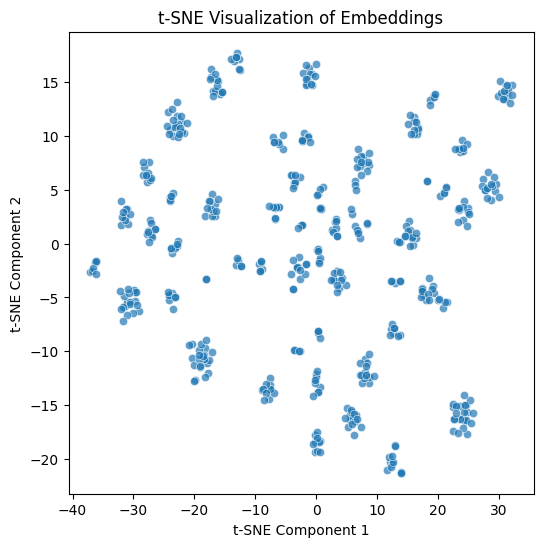

In [94]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# Plot the reduced embeddings
plt.figure(figsize=(6, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.7, edgecolors='w', linewidth=0.5)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of Embeddings')
plt.show()


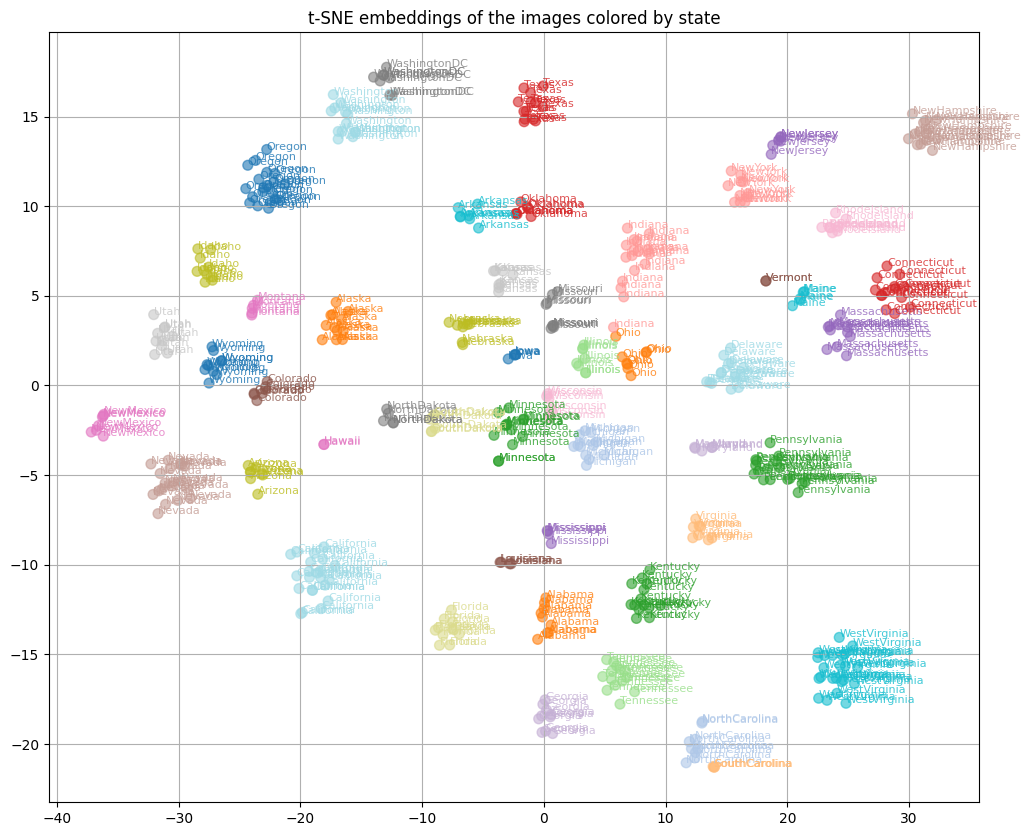

In [111]:
import numpy as np
import matplotlib.cm as cm

# Get unique states and their count
unique_states = list(set(image_labels))
num_unique_states = len(unique_states)

# Create a colormap with the desired number of colors
colors = cm.tab20(np.linspace(0, 1, num_unique_states))

# Create a dictionary to map each state to its corresponding color
state_to_color = {state: color for state, color in zip(unique_states, colors)}

# Map the labels to colors based on the image_labels list
label_colors = [state_to_color[state] for state in image_labels]


plt.figure(figsize=(12, 10))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=label_colors, s=50, alpha=0.6)

# Create a legend
for state, color in state_to_color.items():
    plt.plot([0], [0], color=color, label=state)

# Annotate each point with its state label
for i, state in enumerate(image_labels):
    plt.annotate(state, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]), fontsize=8,
                 color=state_to_color[state], alpha=0.8)

plt.title("t-SNE embeddings of the images colored by state")

plt.grid(True)
plt.show()


In [54]:
# Extract a single text_embedding and image_embedding from the first sample
sample_text_embedding = all_embeddings[0]['text_embedding']
sample_image_embedding = all_embeddings[0]['image_embedding']

# Check the shape or length of these embeddings
len_sample_text_embedding = len(sample_text_embedding)
len_sample_image_embedding = len(sample_image_embedding)

len_sample_text_embedding, len_sample_image_embedding

(1408, 1408)

In [115]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(reduced_embeddings, image_labels, test_size=0.2, random_state=0, stratify=image_labels)

# Create and train a KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors
knn_classifier.fit(X_train, y_train)

# Predict the states for the test data
y_pred = knn_classifier.predict(X_test)

# Calculate the accuracy of the predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.98


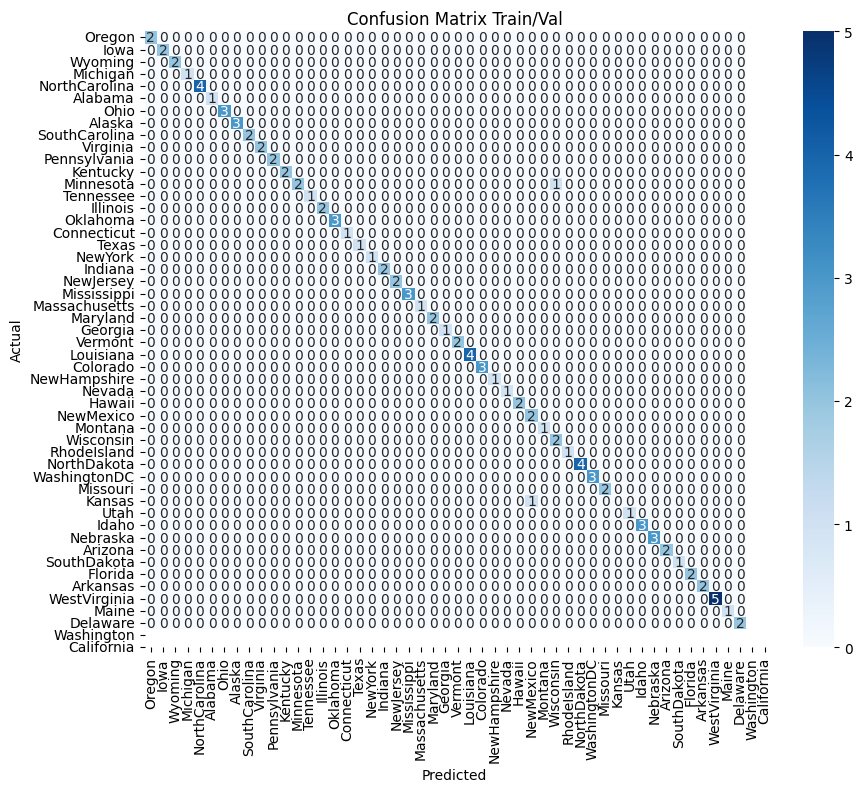

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=unique_states, yticklabels=unique_states)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Train/Val')
plt.show()


In [ ]:
# Create the two generators
#train_gen = data_generator(train_data, char_to_num, batch_size=batch_size)
#val_gen = data_generator(val_data, char_to_num, batch_size=batch_size)
# Test the generators
#train_inputs, train_outputs = next(train_gen)
#val_inputs, val_outputs = next(val_gen)

subset_size = len(data_list)
subset_data = random.sample(data_list, subset_size)
new_processed_images, processed_edgesT, new_image_labels = data_generator(subset_data, char_to_num)
#processed_images, image_labels = data_generator(data_list, char_to_num)

#final_inputs = next(final)


In [ ]:
import time

# Assuming you've already defined the functions and other necessary elements from previous steps...

# Step 1: Generate embeddings for the new validation samples
new_all_embeddings = []

for i, (img_data, state_label) in enumerate(zip(new_processed_images, new_image_labels)):

    # If i is a multiple of 120 and i is not 0, sleep for 60 seconds
    if i % 120 == 0 and i != 0:
        time.sleep(60)

    input_text = f'license plate from {state_label.lower()}'
    embedding = get_embedding_for_image_np(img_data, input_text, 'fifth-composite-395916')
    new_all_embeddings.append(embedding)

# Step 2: Concatenate embeddings
new_concatenated_embeddings = [sample['text_embedding'] + sample['image_embedding'] for sample in new_all_embeddings]
new_concatenated_embeddings_array = np.array(new_concatenated_embeddings)

# Step 3: Apply t-SNE to the concatenated embeddings array
new_reduced_embeddings = tsne.fit_transform(new_concatenated_embeddings_array)

# 'new_reduced_embeddings' now contains the t-SNE reduced embeddings for the new validation samples.


In [121]:
from scipy.stats import ks_2samp

def compare_distributions(embedding1, embedding2):
    statistic, p_value = ks_2samp(embedding1, embedding2)
    if p_value > 0.05:
        print("The distributions are likely similar.")
        print('p = ', p_value)
    else:
        print("The distributions are likely different.")
        print('p = ', p_value)

# Comparing image embeddings as an example
compare_distributions(reduced_embeddings[:, 0], new_reduced_embeddings[:, 0])  # Compare first dimension as an example


The distributions are likely different.
p =  4.6058429552099355e-09


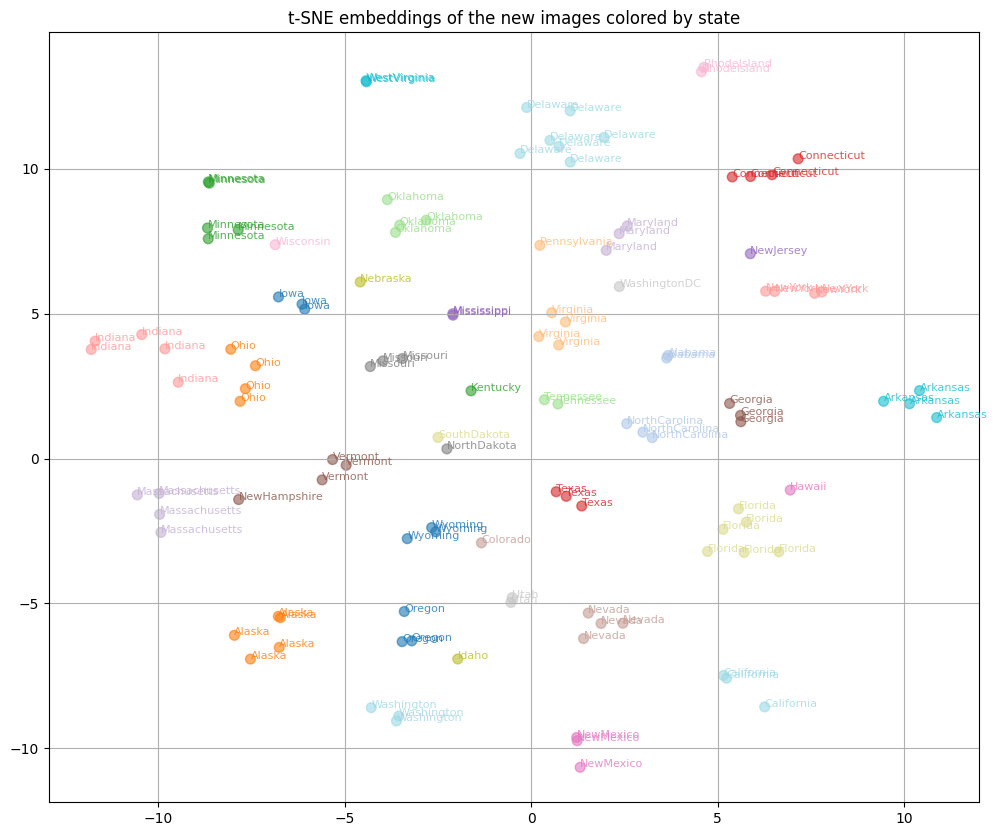

In [114]:
# Assuming new_image_labels is defined and contains the labels for the new validation samples

# Get unique states and their count from the new data
new_unique_states = list(set(new_image_labels))
new_num_unique_states = len(new_unique_states)

# Create a colormap with the desired number of colors for the new data
new_colors = cm.tab20(np.linspace(0, 1, new_num_unique_states))

# Create a dictionary to map each state to its corresponding color for the new data
new_state_to_color = {state: color for state, color in zip(new_unique_states, new_colors)}

# Map the labels to colors based on the new_image_labels list
new_label_colors = [new_state_to_color[state] for state in new_image_labels]

# Visualization for the new data
plt.figure(figsize=(12, 10))
plt.scatter(new_reduced_embeddings[:, 0], new_reduced_embeddings[:, 1], c=new_label_colors, s=50, alpha=0.6)

# Create a legend for the new data
for state, color in new_state_to_color.items():
    plt.plot([0], [0], color=color, label=state)

# Annotate each point with its state label for the new data
for i, state in enumerate(new_image_labels):
    plt.annotate(state, (new_reduced_embeddings[i, 0], new_reduced_embeddings[i, 1]), fontsize=8,
                 color=new_state_to_color[state], alpha=0.8)

plt.title("t-SNE embeddings of the new images colored by state")

plt.grid(True)
plt.show()


Accuracy: 0.016666666666666666


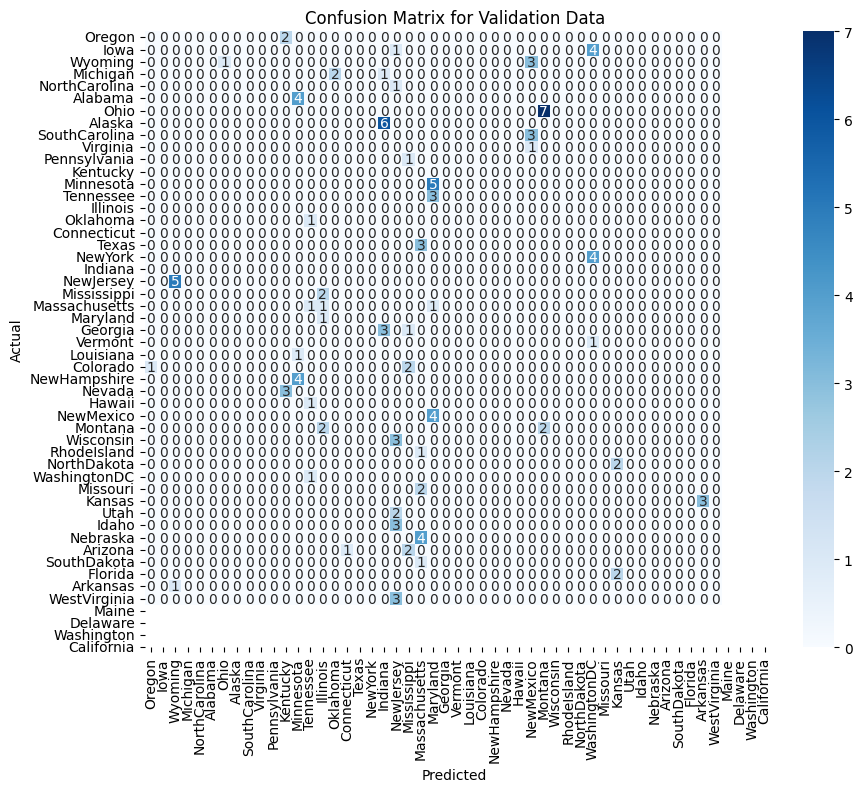

In [113]:
# Step 3: Predict labels for these reduced embeddings using the trained KNN classifier
new_y_pred = knn_classifier.predict(new_reduced_embeddings)

# Step 4: Generate and visualize the confusion matrix for the predicted labels
new_cm = confusion_matrix(new_image_labels, new_y_pred)
# Calculate the accuracy of the predictions
accuracy = accuracy_score(new_image_labels, new_y_pred)
print("Accuracy:", accuracy)
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(new_cm, annot=True, fmt='g', cmap='Blues', xticklabels=unique_states, yticklabels=unique_states)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Validation Data')
plt.show()
